In [2]:
%config InlineBackend.figure_format = "svg"

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

# Import data

In [2]:
# Path of the data
datapath = "data"

# Files to gather
files = glob(datapath + "/*.h5")

# Display all available files
print(files)

['data/wohg_hq1200.h5', 'data/hg3000_hq1000.h5', 'data/fcnc.h5', 'data/wohg_hq1400.h5', 'data/hg3000_hq1400.h5', 'data/hg3000_hq1200.h5', 'data/wohg_hq1000.h5', 'data/bkg.h5']


## Apply data-cuts

In [3]:
def cut_df(file: str, seed: int, sup_split:float):
    """
    A function that applies cuts to an .h5 or .csv data file.
    Returns a pandas dataframe.
    
    Data-cuts applied according to model transferability paper: https://arxiv.org/pdf/1912.04220.pdf
        - At least 2 final state leptons
        - At least 1 b-tagged jet
        - Must have a large scalar sum of transverse momentum (>500GeV)
    """
    
    # Assertions
    assert seed > 0, "Invalid seed."
    assert (sup_split) > 0 and (sup_split < 1), "Invalid split."
    
    # Read dataframe and sort indices
    df = pd.read_hdf(file)
    df = df.sort_index()
    
    # Initial size
    initial_size = len(df)
    
    # Apply data cuts
    df = df[(df["Electron_Multi"] + df["Muon_Multi"]) > 1]
    df = df[(df["Jet1_BTag"] + df["Jet2_BTag"] + df["Jet3_BTag"] + df["Jet4_BTag"] + df["Jet5_BTag"]) > 0]
    df = df[df["ScalarHT_HT"] > 500]
    
    # Determine cut ratio
    split = df["gen_split"].iloc[0].capitalize()
    cut_ratio = 100 * (initial_size - len(df)) / initial_size
    
    # Meta split: support and query data
    df["gen_meta_split"] = "query"
    sample_indices = df.sample(frac=sup_split).index.values
    df.loc[sample_indices, "gen_meta_split"] = "sup"
    
    # Renormalize weights for the meta split
    for split in ["train", "test", "val"]:
        for meta_split in ["sup", "query"]:
            mask = (df["gen_split"] == split) & (df["gen_meta_split"] == meta_split)
            df.loc[mask, "gen_weights"] = df[mask]["gen_xsec"] / df[mask].shape[0]
    
    # Display cut ratio information
    filename = file.split("/")[-1].split(".")[0]
    print(f"File: {filename} | Drop ratio: {cut_ratio}%")
    
    return df

In [4]:
# Define data parameters
data_dict = {}
random_seed = 42
sup_split = 0.3

# Populate data dict
columns = []
for file in tqdm(files, total=len(files), desc="Processing data"):
    # Insert data into dictionary
    filename = file.split("/")[-1].split(".")[0]
    data_dict[filename] = cut_df(file, random_seed, sup_split)
    
    # Insert columns in column list
    columns.append(set(data_dict[filename].columns.to_list()))

Processing data:  12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

File: wohg_hq1200 | Drop ratio: 3.169875545154771%


Processing data:  25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

File: hg3000_hq1000 | Drop ratio: 2.443991853360489%


Processing data:  38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

File: fcnc | Drop ratio: 0.0%


Processing data:  50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

File: wohg_hq1400 | Drop ratio: 2.757437070938215%


Processing data:  62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

File: hg3000_hq1400 | Drop ratio: 2.1137614678899084%


Processing data:  75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

File: hg3000_hq1200 | Drop ratio: 2.3649893170264495%


Processing data:  88%|████████▊ | 7/8 [00:04<00:00,  1.78it/s]

File: wohg_hq1000 | Drop ratio: 3.4287204223974967%


Processing data: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it]

File: bkg | Drop ratio: 0.33191496821583044%


In [15]:
# Determine different columns along dataframes
union_set = set.union(*columns)
intersection_set = set.intersection(*columns)
drop_cols = list(union_set - intersection_set)

# Remove the different columns (so that the data all has the same features and shape)
for file in tqdm(files, total=len(files), desc="Removing extra columns"):
    filename = file.split("/")[-1].split(".")[0]
    data_dict[filename] = data_dict[filename].drop(columns=drop_cols, errors="ignore")
    assert len(data_dict[filename].columns.to_list()) == len(intersection_set), "Number of columns is wrong"

Removing extra columns: 100%|██████████| 8/8 [00:00<00:00, 14.62it/s]


## Plot the data

In [18]:
def plot_histograms(plot_dict, files: [(str, str, str)], scale="log", bins=50):
    """
    A function that draws the histograms of the data
    """
    
    # Assertions
    assert len(files) > 0, "Choose at least one file to plot"
    
    # Select the correct data splits
    data_dict = {}
    for file, split, meta_split in files:
        df = plot_dict[file]
        if split != "all": df = df[df["gen_split"] == split]
        if meta_split != "all": df = df[df["gen_meta_split"] == meta_split]
        data_dict[f"{file} {split} {meta_split}"] = df
    files = [f"{file[0]} {file[1]} {file[2]}" for file in files]
        
    # Get features to plot
    drop_cols = [col for col in data_dict[files[0]].columns.to_list() if "gen" in col]
    features = data_dict[files[0]].drop(columns=drop_cols).columns.to_list()
    
    # Define rows and columns for subplot
    columns = 5
    rows = int(np.ceil(len(features)/columns))
    
    # Create axis
    fig, axs = plt.subplots(rows, columns, figsize=(40, 60))
    
    # Plot every feature
    for i, feature in enumerate(features):
        # Define histogram range
        hist_min = min([data_dict[file][feature].min() for file in files])
        hist_max = max([data_dict[file][feature].max() for file in files])
        hist_range = (hist_min, hist_max)

        # Adjust plot axis
        row, col = i // columns, i % columns
        axs[row, col].set_title(features[i])
        axs[row, col].set_yscale(scale)
        
        # Plot histogram for each file 
        for file in files:
            axs[row, col].hist(data_dict[file][feature], bins=bins, label=file, alpha=0.8, range=hist_range,
                               weights=data_dict[file]["gen_weights"], histtype='step')
        axs[row, col].legend()
    plt.show()

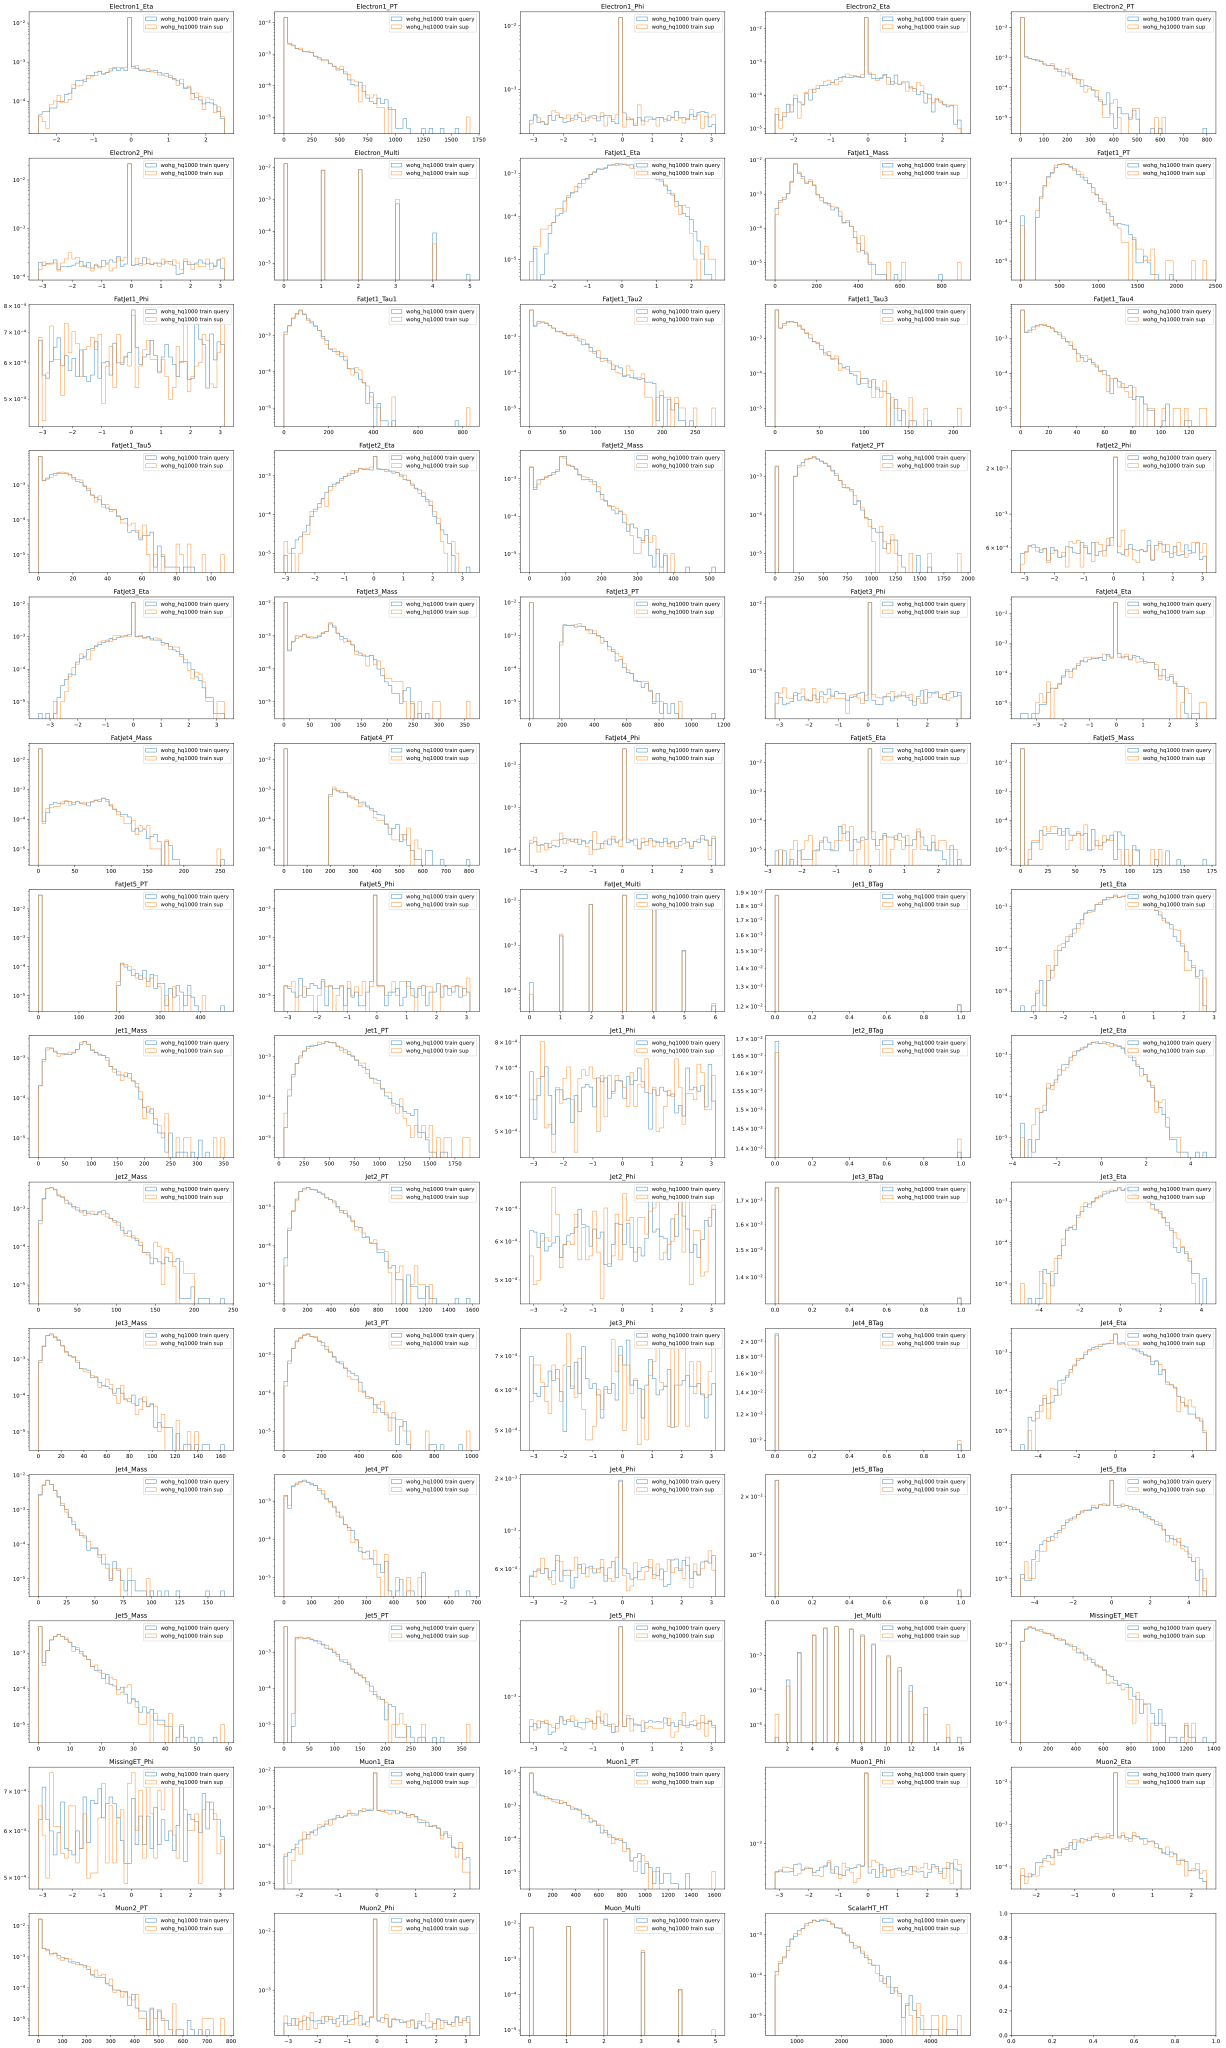

In [19]:
# Plot arguments
plot_files = [("wohg_hq1000", "train", "query"), ("wohg_hq1000", "train", "sup")]
scale = "log"
bins = 50

# Plot the histograms
plot_histograms(data_dict, plot_files, scale, bins)

### Save processed data as .h5 files

In [41]:
savepath = "processed-data/"
for filename in data_dict:
    data_dict[filename].to_hdf(savepath + filename + ".h5", key="df")

# Create a DataSet and Task class

In [38]:
class MetaHEPDataset(Dataset):
    """
    A Dataset class for the processed .h5 files.
    Each entry of the dataset contains a tuple of (features, weight, label).
    """
    def __init__(self, signal_path, bkg_path, split, meta_split, same_sample=False):
        # NOTE: BKG HAS NO SAMPLE MATCHING FCNC
        
        # Load and store the data
        signal_df = pd.read_hdf(signal_path)
        bkg_df = pd.read_hdf(bkg_path)
        if same_sample:
            bkg_df = bkg_df[bkg_df["gen_sample"] == signal_df["gen_sample"][0]]
        df = pd.concat([signal_df, bkg_df], ignore_index=True)
        mask = (df["gen_split"] == split) & (df["gen_meta_split"] == meta_split)
        self.__df__ = df[mask].reset_index(drop=True)
        
        # Store weights
        self.__weights__ = self.__df__["gen_xsec"] / self.__df__.shape[0]
        
        # Store labels
        self.__df__["gen_label"] = self.__df__["gen_label"].replace({"bkg": 0.0, "signal": 1.0})
        self.__labels__ = self.__df__["gen_label"]
        
        # Drop gen columns of dataframe
        drop_cols = [col for col in self.__df__ if "gen" in col]
        self.__df__ = self.__df__.drop(columns=drop_cols)
        
    def __len__(self):
        return self.__df__.shape[0]
    
    def __getitem__(self, idx):
        features = torch.tensor(self.__df__.loc[idx, :].values)
        weight = torch.tensor(self.__weights__.loc[idx])
        label = torch.tensor(self.__labels__.loc[idx])
        return features, weight, label

In [49]:
# Get signal files and background file
bkg_file = savepath + "bkg.h5"
signal_files = glob(savepath + "*.h5")
signal_files.remove(bkg_file)

# Select parameters for task generation
split = "train"
sup_shots = 5
query_shots = 15
same_sample = False

# Generate tasks
tasks = {}
# Create the different tasks in the dictionary
for file in tqdm(signal_files, total=len(signal_files), desc="Populating tasks"):
    # Get filename of the corresponding file
    filename = file.split("/")[-1].split(".")[0]

    # Create support and query DataLoaders for the signal file
    supset = MetaHEPDataset(file, bkg_file, split, "sup", same_sample=False)
    queryset = MetaHEPDataset(file, bkg_file, split, "query", same_sample=False)
    suploader = DataLoader(supset, batch_size=sup_shots, shuffle=True)
    queryloader = DataLoader(queryset, batch_size=query_shots, shuffle=True)

    # Add the dataloaders to the dictionary
    tasks[filename] = {}
    tasks[filename]["sup"] = suploader
    tasks[filename]["query"] = queryloader

Populating tasks: 100%|██████████| 7/7 [01:12<00:00, 10.29s/it]


In [56]:
for key in tasks:
    # Support and query dataloaders
    suploader = tasks[key]["sup"]
    queryloader = tasks[key]["query"]
    
    X, w, y = next(iter(suploader))
    print(f"Sup | X: {X.shape}  | w: {w.shape}  | y: {y.shape}")
    X, w, y = next(iter(queryloader))
    print(f"Que | X: {X.shape} | w: {w.shape} | y: {y.shape}")

Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size([15]) | y: torch.Size([15])
Sup | X: torch.Size([5, 69])  | w: torch.Size([5])  | y: torch.Size([5])
Que | X: torch.Size([15, 69]) | w: torch.Size